# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import torch
import numpy as np

from buffer import ReplayBuffer
from collections import deque
from maddpg import MADDPG


def seeding(seed=3):
    """Set the seeds."""
    np.random.seed(seed)
    torch.manual_seed(seed)


class Experiment:
    """Experiment with MADDP Agent
    
    Args:
        params (dict): Parameters for the agent, noise and buffer
        env (UnityEnvironment): Environment
        brain_name (str): Name of the brain used for the experiment
        n_episodes (int): Maximum number of episodes to play
        checkpoint_path (str): Path used for saving parameters
    
    """
    def __init__(self, params, env, brain_name, n_episodes=10_000, checkpoint_path='checkpoints/agent'):
        self.params = params
        self.env = env
        self.brain_name = brain_name
        self.n_episodes = n_episodes
        self.checkpoint_path = checkpoint_path

        # Get environment info
        brain = env.brains[self.brain_name]
        env_info = env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(env_info.agents)
        self.action_size = brain.vector_action_space_size
        self.state_size = env_info.vector_observations.shape[1]

        # Set the random seed
        seeding(params["random_seed"])

        # Initialize variables for score tracking
        self.scorer = Scorer(num_agents, solved_threshold=0.5)

        # Learning params
        self.steps_before_noise_reduction = params["noise_params"]["initialization_steps"]
        self.initialization_episodes = params["initialization_episodes"]
        self.batch_size = params["batch_size"]
        self.update_every = params["update_every"]
        self.update_batch_number = params["update_batch_number"]
        
        self.step = 0

        # Create agent and buffer
        self.agent = MADDPG(
            self.state_size, self.action_size, params["random_seed"], self.num_agents,
            params["agent_params"], params["network_params"], params["noise_params"]
        )
        self.buffer = ReplayBuffer(params["buffer_size"])
        
        print("Experiment setup done")
        
    def run(self):
        """Run the experiment.
        
        Returns:
            list: Scores of each agent for each episodes.
            
        """
        for i_episode in range(1, self.initialization_episodes + self.n_episodes + 1):
            solved = self.play_episode(i_episode)
            if solved:
                self.agent.save(self.checkpoint_path)
                print(
                    "\rEnvironment solved in {} episodes\tAverage Score: {:.4f}"
                    .format(i_episode, self.scorer.average_score)
                )
                break
        
        return self.scorer.scores
            
    def play_episode(self, i_episode):
        """Play one episode.
        
        Args:
            i_episode (int): Number of the actual episode
            
        """
        self.scorer.start_episode()
        states = self.initialize_episode()
        
        while True:
            # The agent acts
            if i_episode <= self.initialization_episodes:
                actions_array = np.random.uniform(-1, 1, 4).reshape(self.num_agents, self.action_size) 
            else:
                actions = self.agent.act(torch.from_numpy(np.array(states)).float())
                actions_array = torch.stack(actions).detach().numpy().squeeze()

            # Observe the environment
            env_info = self.env.step(actions_array)[self.brain_name]

            next_obs = env_info.vector_observations
            next_states = [agent_state for agent_state in next_obs]

            rewards = np.array(env_info.rewards) 
            dones = np.array(env_info.local_done)

            transition = ([states, actions_array, rewards, next_states, dones])
            self.buffer.push(transition)

            self.scorer.add_rewards(rewards)
            states = next_states

            # Break if episode finished
            if np.any(dones):
                break
                
            # The agent learns
            if (
                len(self.buffer) >= self.batch_size
                and i_episode > self.initialization_episodes
                and self.step % self.update_every == 0
            ):
                for _ in range(self.update_batch_number):
                    for agent_num in range(self.num_agents): 
                        samples = self.buffer.sample(self.batch_size)
                        self.agent.update(samples, agent_num)
        
            if i_episode > self.initialization_episodes:
                self.step += 1

        # Collect the scores
        self.scorer.finish_episode()

        if i_episode > self.initialization_episodes:
            if self.step > self.steps_before_noise_reduction:
                self.agent.reduce_noise()

            if i_episode % 100 == 0:
                print(
                    "\rEpisode {}\tAverage Score: {:.4f}\tNoise Scale: {:.4f}"
                    .format(i_episode, self.scorer.average_score, self.agent.maddpg_agent[0].noise.scale)
                )

        elif i_episode == self.initialization_episodes:
            print("Initialization done")

        # The environment is solved if the average score for the last 100 episodes is at least 0.5
        return self.scorer.solved
    
    def initialize_episode(self):
        """Reset the environment and get the initial state
        
        Returns:
            list of torch.FloatTensor: State after reset
        
        """
        env_info = self.env.reset(train_mode=True)[self.brain_name]
        obs = env_info.vector_observations
        states = [agent_state for agent_state in obs]
        self.agent.reset()
        
        return states
        
        
class Scorer:
    """Keeps track of the experiment scores
    
    Args:
        num_agents (int): Number of agents
        solved_threshold (float): 
        
    """
    def __init__(self, num_agents, solved_threshold):
        self.num_agents = num_agents
        self.solved_threshold = solved_threshold
        
        self.scores_agent = [list() for i in range(self.num_agents)]
        self.max_scores_deque = deque(maxlen = 100)
        
    def start_episode(self):
        self.score = np.zeros(self.num_agents)
        
    def add_rewards(self, rewards):
        self.score += rewards
        
    def finish_episode(self):
        for agent_num in range(self.num_agents):
            self.scores_agent[agent_num].append(self.score[agent_num])

        self.max_scores_deque.append(np.max(self.score))

    @property
    def solved(self):
        return self.average_score >= self.solved_threshold

    @property
    def average_score(self):
        return np.mean(self.max_scores_deque)

    @property
    def scores(self):
        return self.scores_agent

In [6]:
params = {
    "buffer_size": int(1e6),        # Replay buffer size
    "batch_size": 256,              # Minibatch size
    "update_every": 15,             # Steps to wait between updates
    "update_batch_number": 15,      # Number of batches used in one update step
    "random_seed": 4,               # Seed
    "initialization_episodes": 10,  # Number of episodes played with random agent
    "agent_params": {
        "gamma": 0.95,              # Discount factor
        "tau": 5e-3,                # For soft update of target parameters
        "lr_actor": 3e-4,           # Learning rate of the actor 
        "lr_critic": 1e-3,          # Learning rate of the critic
        "weight_decay": 1e-6,       # L2 weight decay
    },
    "network_params": {
        "actor": {
            "fc1_units": 384,       # Number of unit in the first layer of the actor
            "fc2_units": 256,       # Number of unit in the second layer of the actor
        },
        "critic": {
            "fc1_units": 384,       # Number of unit in the first layer of the critic
            "fc2_units": 256,       # Number of unit in the second layer of the critic
        }
    },
    "noise_params": {
        "scale": 1.0,               # Starting scale of the noise
        "mu": 0,                    # Starting values of the noise
        "sigma": 0.4,               # Scaler of the random term
        "theta": 0.2,               # Scaler of the deterministic term
        "noise_reduction": 0.9995,  # The noise is multiplied with this term after each step
        "min_noise": 0.1,           # Minimum noise for the actions
        "initialization_steps": 1000,  # Steps without noise reduction
    },
}


agent_scores = Experiment(params, env, brain_name, checkpoint_path="checkpoints/maddpg_agent").run()

Experiment setup done
Initialization done
Episode 100	Average Score: 0.0039	Noise Scale: 0.9896
Episode 200	Average Score: 0.0038	Noise Scale: 0.9413
Episode 300	Average Score: 0.0087	Noise Scale: 0.8954
Episode 400	Average Score: 0.0403	Noise Scale: 0.8517
Episode 500	Average Score: 0.0586	Noise Scale: 0.8101
Episode 600	Average Score: 0.0507	Noise Scale: 0.7706
Episode 700	Average Score: 0.0705	Noise Scale: 0.7330
Episode 800	Average Score: 0.0816	Noise Scale: 0.6973
Episode 900	Average Score: 0.0818	Noise Scale: 0.6633
Episode 1000	Average Score: 0.0911	Noise Scale: 0.6309
Episode 1100	Average Score: 0.1132	Noise Scale: 0.6001
Episode 1200	Average Score: 0.1709	Noise Scale: 0.5708
Episode 1300	Average Score: 0.3001	Noise Scale: 0.5430
Episode 1400	Average Score: 0.4432	Noise Scale: 0.5165
Environment solved in 1414 episodes	Average Score: 0.5041


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
max_scores = [np.max(score) for score in zip(*agent_scores)]

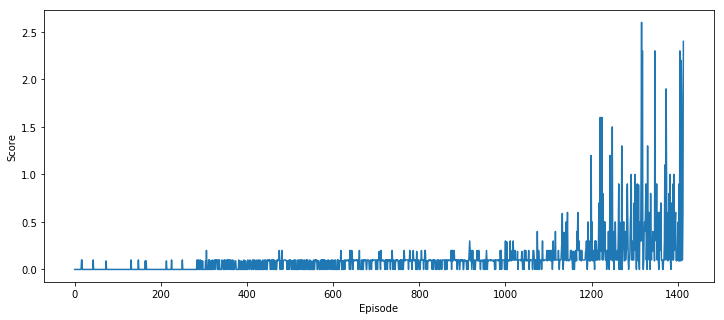

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(range(len(max_scores)), max_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.savefig("solution.png")